In [220]:
import pandas as pd
import numpy as np
import urllib
import pymongo
from pymongo import MongoClient
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import lxml
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

From experimentation, I found that www.pgatour.com stores the majority of their stats pages in the range of 101 - 300 in the path /stats/stat.NUMBER.YEAR.html - This makes it a great target for web scraping.  Let's create a master dictionary of which number corresponds to which stat for 2018 to start

So, for instance I could load the dictionary and look for 'Driving Accuracy Percentage' and easily find which webpage to scrape in the range of 101 - 300

In [2]:
##dont parse the whole page each time to gain a bit of extra performance
stat_name_strainer = SoupStrainer("div", class_="breadcrumbs")
stat_read_dict = {}
stat_range_list = [] #create a list of stat pages that are valid on pgatour.com to use later

for i in range(101, 300):
    stat_url = "https://www.pgatour.com/stats/stat.{0}.2018.html".format(i)
    print(i)
    try:
        web_page = urllib.request.urlopen(stat_url).read()
        soup = BeautifulSoup(web_page, "lxml", parse_only=stat_name_strainer)
        stat_name = soup.find("a", class_="current").text
        if stat_name != "":  #make sure we found data for that number
            stat_read_dict[stat_name] = i
            stat_range_list.append(i)
    except AttributeError:
        print("page number: {0} isn't there".format(i))
        continue


101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
page number: 121 isn't there
122
123
page number: 123 isn't there
124
page number: 124 isn't there
125
page number: 125 isn't there
126
page number: 126 isn't there
127
128
page number: 128 isn't there
129
130
131
132
133
page number: 133 isn't there
134
page number: 134 isn't there
135
136
page number: 136 isn't there
137
138
139
140
141
page number: 141 isn't there
142
143
144
145
146
147
148
149
150
151
page number: 151 isn't there
152
153
154
155
156
157
page number: 157 isn't there
158
159
160
161
page number: 161 isn't there
162
page number: 162 isn't there
163
page number: 163 isn't there
164
page number: 164 isn't there
165
page number: 165 isn't there
166
page number: 166 isn't there
167
page number: 167 isn't there
168
page number: 168 isn't there
169
page number: 169 isn't there
170
page number: 170 isn't there
171
172
173
174
page number: 174 isn't there
175
page number: 175 isn't there
176


Once we have retrieved which page number stores which stat, make sure we store the info locally (python's pickle library works perfectly here).  Future versions of this project will use a database

**Note on database type: Because each stat page contains differently structured data, I most likely want to use a noSQL database to store and return entries.  I can index by player name and year (which together are unique for each stat type)

In [4]:
##Save the stat dict
with open('golf_page_dict.pickle', 'wb') as handle:
    pickle.dump(stat_read_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

##Save the list of valid page numbers for later searching
with open('golf_stat_list.pickle', 'wb') as handle:
    pickle.dump(stat_range_list, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [191]:
##Open the golf page dict
golf_stat_dict = {}
with open('golf_page_dict.pickle', 'rb') as handle:
    golf_stat_dict = pickle.load(handle)
golf_stat_dict

{"3-Putt Avoidance - 15-20'": 145,
 "3-Putt Avoidance - 20-25'": 146,
 "3-Putt Avoidance > 25'": 147,
 'All-Around Ranking': 127,
 'Back 9 Par 3 Scoring Average': 222,
 'Back 9 Par 4 Scoring Average': 230,
 'Back 9 Par 5 Scoring Average': 238,
 'Back 9 Round 1 Scoring Average': 246,
 'Back 9 Round 2 Scoring Average': 254,
 'Back 9 Round 3 Scoring Average': 262,
 'Back 9 Round 4 Scoring Average': 270,
 'Back 9 Round 5 Scoring Average': 278,
 'Back 9 Scoring Average': 208,
 'Ball Striking': 158,
 'Best YTD 1-Putt or Better Streak': 295,
 'Best YTD Streak w/o a 3-Putt': 294,
 'Birdie Average': 156,
 'Birdie or Better Conversion Percentage': 115,
 'Bounce Back': 160,
 'Career Money Leaders': 110,
 'Consecutive Cuts': 122,
 'Consecutive Fairways Hit': 297,
 'Consecutive GIR': 298,
 'Consecutive Sand Saves': 296,
 'Current Par or Better Streak': 150,
 'Driving Accuracy Percentage': 102,
 'Driving Distance': 101,
 'Driving Pct. 240-260 (All Drives)': 217,
 'Driving Pct. 260-280 (All Drives)':

So I can start doing some web scraping across different stats and years now.  I have the information to find specific stats via the golf_stat_dict + URL and can select years easily as well

Let's try to figure out who made the most money per event from 2010 - 2018, something that the PGA tour's website doesn't let you easily do.  

'Money per Event Leaders' is the stat that we want to look at

In [199]:
years_to_check = ['2018','2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']
multiple_year_stat = []

def df_stat_retriever(stat_name): 
    stat_num = golf_stat_dict[stat_name]

    for year in years_to_check:
        stat_url = "https://www.pgatour.com/stats/stat.{0}.{1}.html".format(stat_num, year)
        search_dict = {'id' : 'statsTable'} #Each page has a statsTable ID on the table header
        stat_data = pd.read_html(stat_url, attrs = search_dict) #pandas has a nifty way to scrape an html table directly off of a page
        stat_data[0]['YEAR'] = year
        multiple_year_stat.append(stat_data[0])

    
    return pd.concat(multiple_year_stat)



In [185]:
multiple_year_stat_dframe = df_stat_retriever('Money per Event Leaders')

In [188]:
#Some data cleaning to get rid of commas, get rid of dollar signs and convert to int
multiple_year_stat_dframe['MONEY PER EVENT'] = multiple_year_stat_dframe['MONEY PER EVENT'].replace({'\$':'', ',':''}, regex=True).astype(int)
multiple_year_stat_dframe['TOTAL MONEY'] = multiple_year_stat_dframe['TOTAL MONEY'].replace({'\$':'', ',':''}, regex=True).astype(int)



In [189]:
#Average money made per event across the tour over the last 8 years:
print(multiple_year_stat_dframe['MONEY PER EVENT'].mean()) #--> $45,097.74

#Average total money made per year across the tour over the last 8 years:
print(multiple_year_stat_dframe['TOTAL MONEY'].mean()) #--> $837,846.61

#20 highest earning years for players
print(multiple_year_stat_dframe.nlargest(20, 'TOTAL MONEY'))

# 1) Jordan Speith, 2015, $12,030,464
# 2) Justin Thomas, 2017, $9,921,559
# 3) Jordan Spieth, 2017, $9,433,032
# Interestingly, Tiger woods shows up on this list once as number 8 (2013), 
# but has the highest money earned per event because he only played 
# 16 events, tied for the lowest number


45097.740093603745
837846.6053042122
  RANK THIS WEEK RANK LAST WEEK        PLAYER NAME  EVENTS  MONEY PER EVENT  \
0              1              1      Jordan Spieth      25           481218   
2              3            NaN      Justin Thomas      25           396862   
1              2            NaN      Jordan Spieth      23           410131   
1              2              2          Jason Day      20           470166   
0              1              1     Dustin Johnson      22           425690   
0              1            NaN     Dustin Johnson      20           436609   
3              4              4      Justin Thomas      23           378035   
0              1              1        Tiger Woods      16           534589   
1              2              2     Dustin Johnson      20           422867   
3              4            NaN   Hideki Matsuyama      22           380934   
0              1              1       Rory McIlroy      17           487064   
0              

Simple visualization: How did total money and money earned per event fluctuate for Jordan Speith (arguably the most successful player of the last 5 years)?

   RANK THIS WEEK RANK LAST WEEK    PLAYER NAME  EVENTS  MONEY PER EVENT  \
36             37             37  Jordan Spieth      23           121458   
1               2            NaN  Jordan Spieth      23           410131   
4               5              5  Jordan Spieth      21           263736   
0               1              1  Jordan Spieth      25           481218   
15             16             16  Jordan Spieth      27           160842   
9              10             10  Jordan Spieth      23           168687   

    TOTAL MONEY  YEAR  
36      2793536  2018  
1       9433032  2017  
4       5538470  2016  
0      12030464  2015  
15      4342748  2014  
9       3879819  2013  


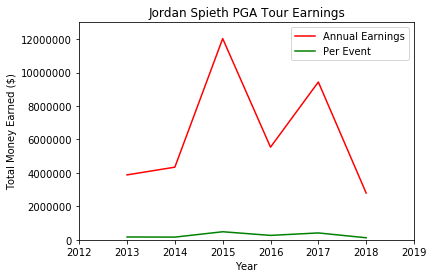

In [180]:
spieth_dframe = multiple_year_stat_dframe.loc[multiple_year_stat_dframe['PLAYER NAME'] == 'Jordan Spieth'].sort_values('YEAR', ascending=False)
print(spieth_dframe)

plt.plot(spieth_dframe['YEAR'], spieth_dframe['TOTAL MONEY'], 'r-')
plt.plot(spieth_dframe['YEAR'], spieth_dframe['MONEY PER EVENT'], 'g-')
plt.axis([2012, 2019, 0, 13000000])
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Money Earned ($)')
plt.xlabel('Year')
plt.title('Jordan Spieth PGA Tour Earnings')
plt.legend(['Annual Earnings', 'Per Event'])
plt.show()

We can now see how Spieth's money earned has fluctuated over the last few years (his entire career).  Obviously 2015 was a breakout year for him in terms of total money and money earned per event.

Lastly, I want to make a hypothesis about which statistic on the PGA tour accurately predicts total money earned for a given year.  I'll use a simple linear regression.

I am curious about how impactful 'Greens in Regulation Percentage' as a statistic is on the PGA tour.  Greens in Regulation Percentage is a statistic measuring how often a player makes it onto a green with a chance for a birdie or better

In [241]:
df_GIR_percentage = df_stat_retriever('Greens in Regulation Percentage')

In [219]:
# To set up the side-by-side comparison of Greens in Regulation for a given year vs Money Earned 
# we have to essentially perform an inner join across the 2 dataframes.  This can be done very 
# easily with pandas.merge
merged_df = pd.merge(df_GIR_percentage, multiple_year_stat_dframe, on = ['PLAYER NAME', 'YEAR'])
merged_df = merged_df[['PLAYER NAME', '%', 'YEAR', 'TOTAL MONEY']] #get rid of the uneeded columns that are NaN now

Coefficients: 
 [ 246105.57765697]
Mean squared error: 1683155039981.29
Variance score: 0.03


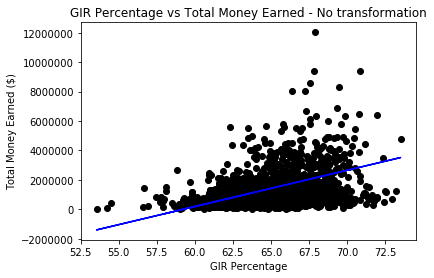

In [240]:
# To train a linear model and see how well it predicts
# my data, I will split my dataset 20:80, 20% training 
# data, 80% predictive data

#merged_df.describe --> 1678 total rows.  20% = 335, 80% = 1343
stats_train = merged_df.head(335)
stats_X_train = stats_train['%']
stats_Y_train = stats_train['TOTAL MONEY']

stats_test = merged_df.tail(1343)
stats_X_test = stats_test['%']
stats_Y_test = stats_test['TOTAL MONEY']

regr = linear_model.LinearRegression()
regr.fit(stats_X_train.values.reshape(-1, 1), stats_Y_train)

#Make a prediction using the testing set
stats_Y_pred = regr.predict(stats_X_test.values.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(stats_Y_test, stats_Y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(stats_Y_test, stats_Y_pred))

plt.ticklabel_format(style='plain', axis='y')
plt.title('GIR Percentage vs Total Money Earned - No transformation')
plt.ylabel('Total Money Earned ($)')
plt.xlabel('GIR Percentage')
plt.scatter(stats_X_test, stats_Y_test, color='black')
plt.plot(stats_X_test, stats_Y_pred, color='blue')
plt.show()


Coefficients: 
[ 246105.57765697], 
Mean squared error: 1683155039981.29, 
Variance score: 0.03

We can see that based on this model, Greens in Regulation Percentage is not a great predictor of Total Money Earned.  From the variance score, only 3% of the variance in Total Money is explained by GIR percentage.  

One way to possibly improve this model would be to transform the GIR percentage to spread the data out.  Ie, instead of it being in a possible range of 0-100, we may expand the range and see some separation for our model to predict.
